In [13]:
rm(list = ls())
library(MASS)
library(ggplot2)
library(gridExtra)
library(carData)
library(car)
library(TSA)
library(jtools)

## Data Cleaning 

We first take a glimpse of the raw data to see if they agree with the realistic background, if there is any weird record, outlier or typo.
Since the unit of most of the variables is centimeter, to unify units, we convert the unit of height to centimeter. And to make it easier to calculate bmi (ADIPOSITY), also change the unit of weight to kilogram. Than the formula of bmi becomes:$BMI = \frac{WEIGHT}{{HEIGHT/100}^{2}}$

In [14]:
dat = read.csv("BodyFat.csv", row.names = 1)
dat$WEIGHT=round(dat$WEIGHT*0.45359237,2)
dat$HEIGHT=round(dat$HEIGHT*2.54,2)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   12.80   19.00   18.94   24.60   45.10 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  53.75   72.12   80.06   81.16   89.36  164.72 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  74.93  173.35  177.80  178.18  183.52  197.49 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  22.00   35.75   43.00   44.88   54.00   81.00 

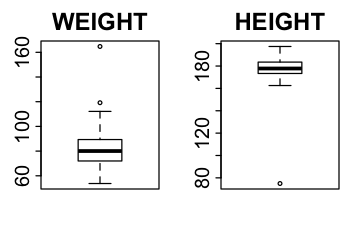

In [15]:
summary(dat$BODYFAT);summary(dat$WEIGHT);summary(dat$HEIGHT);summary(dat$AGE)
options(repr.plot.width=3,repr.plot.height=2,repr.plot.pointsize=5)
par(mfrow=c(1,2))
boxplot(dat$WEIGHT,main="WEIGHT")
boxplot(dat$HEIGHT,main="HEIGHT")

By looking at the dataset summary and boxplots, we detect four weird records: #39 weights extremely heavy, #42 is too short, #79 much older than other men, #182 has zero bodyfat. Then we tried to use the variable values that seem to be true to predict the corresponding outlier variable for these three persons.
However, we are still not sure about whether the four outliers were wrong values or just extreme values, so we check consistency of BMI versus HEIGHT and WEIGHT, also the consistency between density and bodyfat.

#### Consistency of BMI versus HEIGHT and WEIGHT

In [16]:
dat[39,]; dat[42,]; dat[79,]; dat[182,]
dat$HEIGHT[42]=round(sqrt(92.99/29.9)*100,2)#bmi=weight/(height/100)^2 #different from the record, replace it by the new height

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
39,33.8,1.0202,46,164.72,183.52,48.9,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45,29,21.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
42,31.7,1.025,44,92.99,74.93,29.9,36.6,106,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
79,21.1,1.0498,81,73.14,178.44,23,37.8,96.4,95.4,99.3,53.5,37.5,21.5,31.4,26.8,18.3


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
182,0,1.1089,40,53.75,172.72,18.1,33.8,79.3,69.4,85,47.2,33.5,20.2,27.7,24.6,16.5


We change the height of #42 but retain #39 and #79 because it seems that the 79th is a normal thin old man, the 39th is a very heavy man which follows the bmi equation. We'd better keep more information.

#### Consistency between DENSITY and BODYFAT

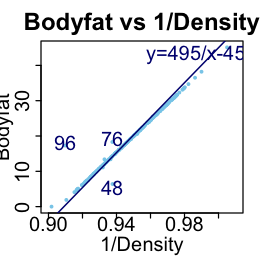

In [17]:
options(repr.plot.width=2.2,repr.plot.height=2.2,repr.plot.pointsize=5)
par(mfrow=c(1,1))
plot(dat$BODYFAT~I(dat$DENSITY^(-1)),xlim=c(0.90,1.01),ylab="Bodyfat",xlab="1/Density",col="skyblue",pch=19,cex=0.7,main="Bodyfat vs 1/Density")
x=seq(0.9,1.01,0.01)
lines(x,y=x*495-450,col="navyblue",lwd=1.2)
text(0.99,43,"y=495/x-450",col="navyblue",cex=1)
text(1/1.0991,18.3,"96",col="navyblue",cex=1)
text(1/1.0665,5.4,"48",col="navyblue",cex=1)
text(1/1.0666,19.3,"76",col="navyblue",cex=1)

In [18]:
dat=dat[-182,]

We delete #182 variable because it can't be imputed by density, the value of 495/1.1089 - 450 is less than zero.
Also, noticing there are three data points whose bodyfat conflict with density use the siri's formula. 
Since we are not sure of the bodyfat and density which one is wrong, we search for a bodyfat calculator as reference to re-calculate these three bodyfat usig Weight and Waist Circumference(Abdomen) two variables.

In [19]:
dat[48,]; dat[96,]; dat[76,]
bodyfat48=495/1.0665-450 #bodyfay wrong
bodyfat96=495/1.0991-450 #density wrong
bodyfat76=495/1.0666-450 #density wrong

,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
48,6.4,1.0665,39,67.36,180.97,20.6,34.6,89.8,79.5,92.7,52.7,37.5,21.9,28.8,26.8,17.9


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
96,17.3,1.0991,53,101.83,197.49,26.1,41.1,113.2,99.2,107.5,61.7,42.3,23.2,32.9,30.8,20.4


,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
76,18.3,1.0666,61,67.25,171.45,22.9,36,91.6,81.8,94.8,54.5,37,21.4,29.3,27,18.3


After checking the bodyfat calculated by siri's formula and by calculator, we got the conclusion that only point 48 has wrong bodyfat and we use siri's formula to impute it.

In [20]:
dat$BODYFAT[48]=bodyfat48
dat=dat[,-2] #delete density

## Variable Selection

In [21]:
m_full<-lm(BODYFAT~.,data=dat) #full model
base=base <- lm(BODYFAT~1,data=dat)
#AIC.base <- step(base,direction="forward",scope=list(lower=~1,upper=m_full),trace=T)

According to the forward variables selection based on AIC above, considering the simplicity, the best models with different number of variables, 1 to 4, are as below:

In [22]:
m1<-lm(BODYFAT~ABDOMEN,data=dat)
m2<-lm(BODYFAT~ABDOMEN+WEIGHT,data=dat)
m3<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST,data=dat)
m4<-lm(BODYFAT~ABDOMEN+WEIGHT+WRIST+FOREARM,data=dat)

The variables selected are mainly Abdomen, Weight and Wrist and we want to look into their relationships and give a intuitive analysis based on data visualization.

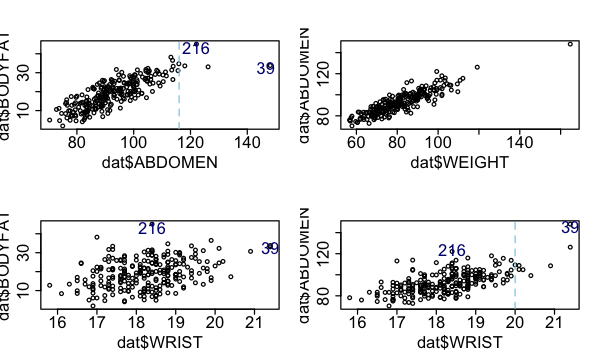

In [23]:
options(repr.plot.width=5,repr.plot.height=3,repr.plot.pointsize=6)
par(mfrow=c(2,2))
plot(dat$BODYFAT~dat$ABDOMEN)
abline(v=116,col="skyblue",lty="dashed")
text(122,43.5,"216",col="navyblue",cex=1)
text(146.5,32.5,"39",col="navyblue",cex=1)
plot(dat$ABDOMEN~dat$WEIGHT)
plot(dat$BODYFAT~dat$WRIST)
text(18.4,43.5,"216",col="navyblue",cex=1)
text(21.4,32.5,"39",col="navyblue",cex=1)
plot(dat$ABDOMEN~dat$WRIST)
abline(v=20,col="skyblue",lty="dashed")
text(18.4,124,"216",col="navyblue",cex=1)
text(21.4,146,"39",col="navyblue",cex=1)

There exists an obvious linear relationship between Abdomen and Weight, so the second model (m2) is unreliable because of the multicollinearity. The vif test and high correlation (0.89) between the two variables also support this statement.
The fourth model (m4) has the same problem of multicollinearity.

|model|ABDOMEN|WEIGHT|WRIST|FOREARM|
|---|---|---|---|---|
|m2 vif|4.73|4.73|  |
|m4 vif|4.86|7.04|2.27|1.79|


Because our goal is to find out a simple and accurate model, we first put Model 4 aside and try to make some improvements on Model 2 and 3.

## Model Modification and Improvement

#### Ridge regression
In order to eliminate multicollinearity of m2 model,we use ridge regression and calculate MSE.

In [24]:
m2_ridge=lm.ridge(BODYFAT~ABDOMEN+WEIGHT,data=dat,lambda = seq(0,10,0.1))
#select(m2_ridge)
m2_ridge=lm.ridge(BODYFAT~ABDOMEN+WEIGHT,data=dat,lambda = 0.2)
#calculate MSE
pred.ridge <- coef(m2_ridge)[1] + coef(m2_ridge)[2]*dat$ABDOMEN + coef(m2_ridge)[3]*dat$WEIGHT
y=dat$BODYFAT
y_predicted=pred.ridge
sst <- sum((y - mean(y))^2) #Sum of Squares Total
sse <- sum((y_predicted - y)^2) #SSE
rsq <- 1 - sse / sst # R squared
MSE=mean((y_predicted - y)^2)

#### Nonlinear model with interation term

Althouth there's strong linearity between Abdomen and Bodyfat, Bodyfat is influenced by other factors with higher abdomen level and it seems to be a nonlinear relationship on the right side of the vertical line.
Wrist circumsference has no big influence on lower weight males, but extremely large wrist circumsference will lead to large abdomen circumsference and heavy weight and we can see the Abdomen increases rapidly when Wrist is larger than 20.
To further explore their mutual influences, we turn to use interaction plots.

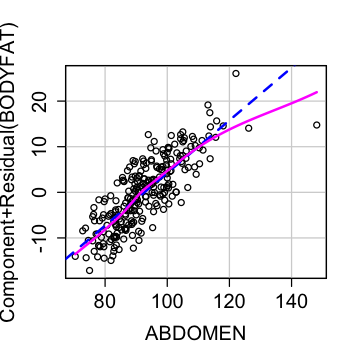

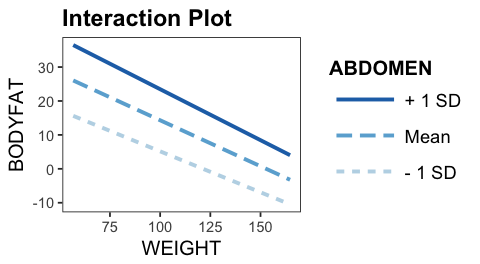

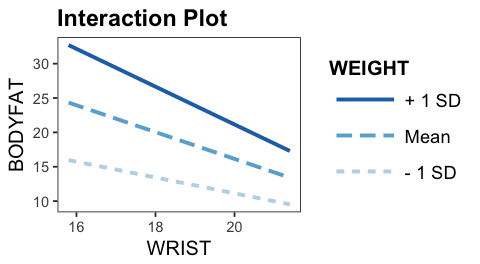

In [25]:
options(repr.plot.width=3,repr.plot.height=3,repr.plot.pointsize=7)
crPlots(m1)
options(repr.plot.width=4,repr.plot.height=2.2,repr.plot.pointsize=8)
interact_plot(lm(BODYFAT~WEIGHT*ABDOMEN,data=dat), pred = "WEIGHT", modx = "ABDOMEN",main="Interaction Plot")
interact_plot(lm(BODYFAT~WEIGHT*WRIST,data=dat), pred = "WRIST", modx = "WEIGHT",main="Interaction Plot")

Out of our expectation, at same Abdomen level, heavier males will have lower bodyfat. Meanwhile, with same weight level, males with larger wrist circumsference will have lower bodyfat.
Therefore, we decide to include the WEIGHT:WRIST interaction term into our model, to interprete their complicated relationships, and it turns out to be a really good model.

In [26]:
m5<-lm(BODYFAT~ABDOMEN+WEIGHT:WRIST,data=dat)
#summary(m5)
mse5=mean(m5$residuals^2)

## Model Comparison

| Model | Adj.R-squared | MSE |
|---|---|---|
|m2_ridge| 0.7127 | 16.69 |
|m3| 0.7185 | 16.16 |
|m5| 0.7258 | 15.80|

m2_ridge is improved from m2 and m5 is improved from m3. Table below examines the accuracy of these two models by adjusted $R^{2}$ and the MSE. As is shown, model 5 (m5) is much better according to both criteria. Therefore, we choose model 5 as our final model.

$$ Bodyfat(\%) = -45.3249 + 0.9092\times Abdomen(cm) -0.0133\times Weight(kg)\times Wrist(cm)$$

Below is the coefficients of the model 5 and all of the terms are significant.

|/|Estimate|Std.Error|t value|P value|
|---|---|---|---|---|
|Intercept|-45.3249|2.573|-17.62|<2e-16|
|ABDOMEN| 0.9092| 0.047| 19.42| <2e-16|
|WEIGHT:WRIST|-0.0133|0.002|-8.22|1.14e-14|

## Model Diagnostic

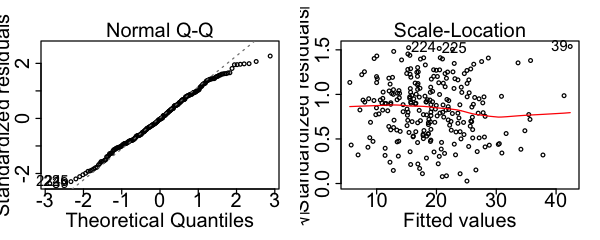

In [27]:
options(repr.plot.width=5,repr.plot.height=2,repr.plot.pointsize=5)
par(mfrow=c(1,2))
plot(m5,which=c(2,3))

#### Normality Assumption

In [28]:
shapiro.test(m5$residuals)


	Shapiro-Wilk normality test

data:  m5$residuals
W = 0.99056, p-value = 0.1039


$H_{0}$: the residual follows normal distribution. 

P-value is larger than $0.05$, retain $H_{0}$. So the residual follows normal distribution.

#### Homoscedasticity Assumption

In [29]:
ncvTest(m5)

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 0.0001924752, Df = 1, p = 0.98893

$H_{0}$: homoscedasticity vs $H_{1}$:variance residuals vary with the level of fitted values

P-value is larger than $0.05$, retain $H_{0}$. So the residual follows homoscedasticity  assumption.

#### Robustness

In [31]:
rlm5=rlm(BODYFAT~ABDOMEN+WEIGHT:WRIST,data=dat)

|/|Value|Std.Error|t value|
|---|---|---|---|
|Intercept|-46.652|2.761|-16.894|
|ABDOMEN| 0.922| 0.051| 18.255|
|WEIGHT:WRIST|-0.013|0.002|-7.558|

The coefficients of the robust model5 are very close to those of the previous model5, which means model5 is robust to some extent.

## Rules of thumb

$$ Bodyfat(\%) = -45 + 0.91\times Abdomen(cm) -0.013\times Weight(kg)\times Wrist(cm)$$

#### Explain the practical meaning of this model:

For a 75 kg man whose abdomen is 85 cm, wrist is 18 cm, his predicted bodyfat is around 14.97%. There is a 95% probability that his bodyfat is between 14.35% and 15.59%. This model is a simpler one to calculate bodyfat, it predicts this person has 14.8% bodyfat.

## Strengths and weakness

Our final model eliminates multicollinearity between the independent variables and gives a relatively accurate prediction of bodyfat. The model is meaningful and interpretable.

Although the model isn't very complicated, it just contains two terms in the formula, it's still not quite easy for people to remember.

#### Contribution and reference

[1] Bodyfat calculator https://www.active.com/fitness/calculators/bodyfat 

[2] M-estimator https://en.wikipedia.org/wiki/M-estimator
